In [10]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

from scipy.interpolate import splprep, splev
from scipy.optimize import minimize


# Onderzoeken van een kleur op een zwart wit-kaartje
- Hoe ziet dit eruit in RGB- ruimte?
- Waar zit $R_{\infty}$ en kan je deze makkelijk identificeren in de RGB ruimte?
- Kan je het kaartje parametriseren?
- Hoe ziet het kaartje eruit geprojecteerd op R,G,B?
- Het bepalen van $R_{\infty}$ aan de hand van twee punten op gelijke dikte. 

### Kaartje maken

From inktime

Parameters for reflectance function (rgbkm.reflectance):

- K: tuple-like (n channels): Colorant absorption coefficients for wavelength or RGB channels
- S: tuple-like (n channels): Colorant scattering coefficients for wavelength or RGB channels
- D: array ( height x width): Colorant thickness image
- Rg: array (height x width x n) or rgb tuple with shape (3,): Background reflectance image or background color
  
Returns:
- refl: array (height x width x n)
- n-channel reflectance image

R_inf from Kubelka-Munk: [0.55198152 0.00684964 0.0053005 ]


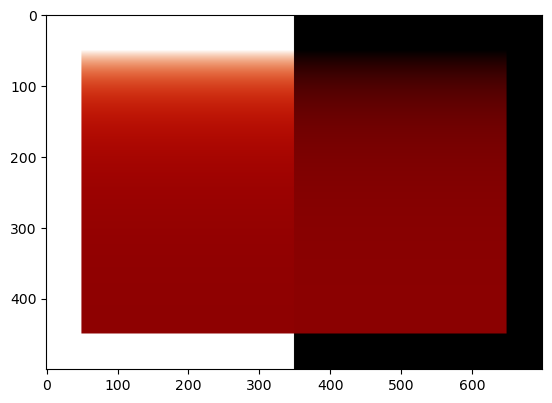

In [14]:
%matplotlib inline

# Black and white background
height, width = 500, 700

Rg = np.ones((height, width, 3))
Rg[:, width // 2:, :] = 0

# Cadmium red (Curtis)
K = np.array([0.14, 1.08, 1.68]) # R, G, B
S = np.array([0.77, 0.015, 0.018])

# Calculate R_inf
a = (K + S) / S
b = np.sqrt(a**2 - 1)
R_inf_true = a - b
print('R_inf from Kubelka-Munk:', R_inf_true)

# Thickness map
border = 50

D_max = 5

D_w = width - 2 * border  # 600
D_h = height - 2 * border  # 400

D_line = np.linspace(0, D_max, D_h)[:, None]      # (400, 1)
D = np.repeat(D_line, D_w, axis=1)  # (400, 600)

D_full = np.zeros((height, width))
D_full[border:border + D_h, border:border + D_w] = D

kaartje = rgbkm.reflectance(K,S,D_full,Rg)

fig, ax = plt.subplots(1)
ax.imshow(kaartje)
plt.show()


### Channels as function of thickness

R_inf from Kubelka-Munk: [0.55198152 0.00684964 0.0053005 ]


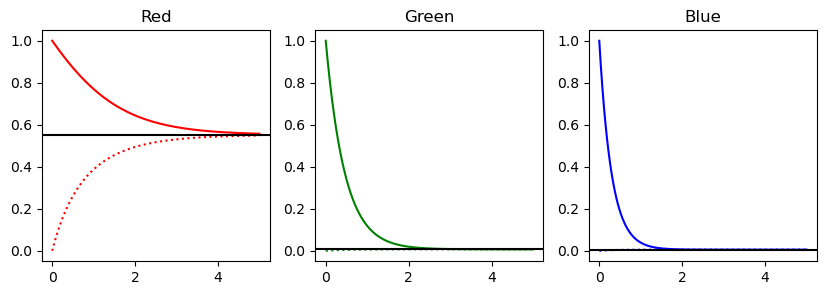

In [17]:
%matplotlib inline

rows = slice(border, border + D_h)
cols_valid = slice(border, border + D_w)
mid = border + D_w // 2

cols_white = slice(border, mid)
cols_black = slice(mid, border + D_w)

D_white = D_full[rows, cols_white]
D_black = D_full[rows, cols_black]

R_white = kaartje[rows, cols_white, :]
R_black = kaartje[rows, cols_black, :]

print('R_inf from Kubelka-Munk:', R_inf_true)
fig, ax = plt.subplots(1,3, figsize = (10,3))
ax[0].set_title(r'Red')
ax[0].plot(D_white.mean(axis=1), R_white[:,:,0].mean(axis=1), color = 'red')
ax[0].plot(D_black.mean(axis=1), R_black[:,:,0].mean(axis=1), color = 'red', linestyle = 'dotted')
ax[0].axhline(R_inf_true[0], 0, width, color = 'k')
    
ax[1].set_title(r'Green')
ax[1].plot(D_white.mean(axis=1), R_white[:,:,1].mean(axis=1), color = 'green')
ax[1].plot(D_black.mean(axis=1), R_black[:,:,1].mean(axis=1), color = 'green', linestyle = 'dotted')
ax[1].axhline(R_inf_true[1], 0, width, color = 'k')

ax[2].set_title(r'Blue')
ax[2].plot(D_white.mean(axis=1), R_white[:,:,2].mean(axis=1), color = 'blue')
ax[2].plot(D_black.mean(axis=1), R_black[:,:,2].mean(axis=1), color = 'blue', linestyle = 'dotted')
ax[2].axhline(R_inf_true[2], 0, width, color = 'k')


plt.show()

### $R_{\infty}$ terug uit het kaartje halen

In [20]:
def RGB_histogram(img, bins = 32, count = False):
    rgb = img.reshape(-1, 3)

    if rgb.max() > 1:
        rgb = rgb / 255.0
    
    hist, edges = np.histogramdd(rgb, bins=(bins, bins, bins), range=((0,1),(0,1),(0,1)))
    
    # Bin centers
    centers = [0.5 * (e[:-1] + e[1:]) for e in edges]
    R, G, B = np.meshgrid(*centers, indexing='ij')
    
    # Flatten
    R = R.ravel()
    G = G.ravel()
    B = B.ravel()
    counts = hist.ravel()
    
    mask = counts > 0
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    if count == True:
        ax.scatter(R[mask], G[mask], B[mask], c =np.stack([R[mask], G[mask], B[mask]], axis=1), s = counts[mask], alpha=0.6)
    elif count == False:
        ax.scatter(R[mask], G[mask], B[mask], c =np.stack([R[mask], G[mask], B[mask]], axis=1), alpha=0.6)
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")

    return fig, ax

### Skeletonize
Finding the curve by projecting it on the principle axis, binning along this axis and taking the average value per bin as point on the curve. Unfortunately this only works for curves that are not too complicated or noisy

In [23]:
def rgb_skeleton(img, N_skel=100):
    """
    Reduce RGB image to a 1D skeleton along the main KM trajectory using PCA
    Returns RGB points along the curve (N_skel, 3)
    """
    rgb = img.reshape(-1, 3)

    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    t = pca.fit_transform(rgb).ravel()

    # Sort by PCA coordinate
    order = np.argsort(t)
    t_sorted = t[order]
    rgb_sorted = rgb[order]

    # Bin edges and centers
    bins = np.linspace(t_sorted.min(), t_sorted.max(), N_skel + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    skeleton = np.empty((N_skel, 3))
    valid = np.zeros(N_skel, dtype=bool)

    inds = np.digitize(t_sorted, bins) - 1

    for i in range(N_skel):
        pts = rgb_sorted[inds == i]
        if len(pts) > 0:
            skeleton[i] = pts.mean(axis=0)
            valid[i] = True

    # Interpolate missing bins along the curve
    for c in range(3):
        skeleton[:, c] = np.interp(
            bin_centers,
            bin_centers[valid],
            skeleton[valid, c]
        )

    return skeleton


In [25]:
%matplotlib widget

In [27]:
N_skel = 1000

skeleton = rgb_skeleton(kaartje)

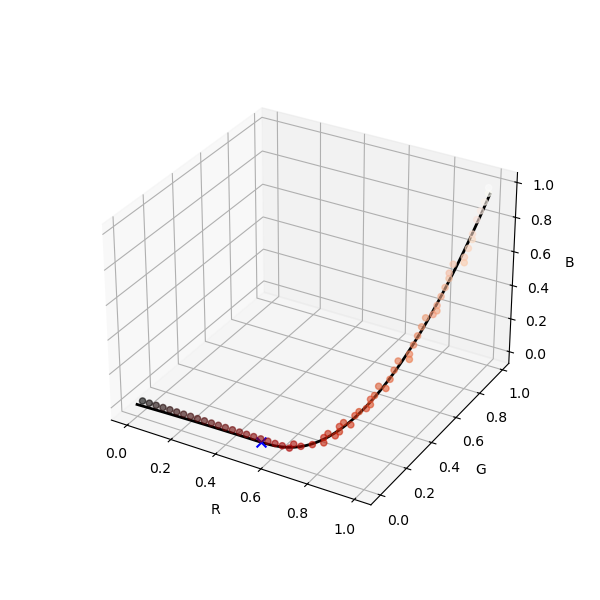

In [29]:
fig, ax = RGB_histogram(kaartje, count = False)
ax.plot(skeleton[:, 0], skeleton[:, 1], skeleton[:, 2], color='black', linewidth=2)
ax.scatter(R_inf_true[0], R_inf_true[1], R_inf_true[2], color = 'b', marker = 'x', s = 50)

plt.show()

### Seperating channels

Trying to find $R_{\infty}$ by finding the minimum of the gradient per channel.
This only works for K >> S.

In [32]:
def arclength_param(P):
    d = np.linalg.norm(np.diff(P, axis=0), axis=1)
    return np.concatenate([[0], np.cumsum(d)])

R_inf from Kubelka-Munk: [0.55198152 0.00684964 0.0053005 ]


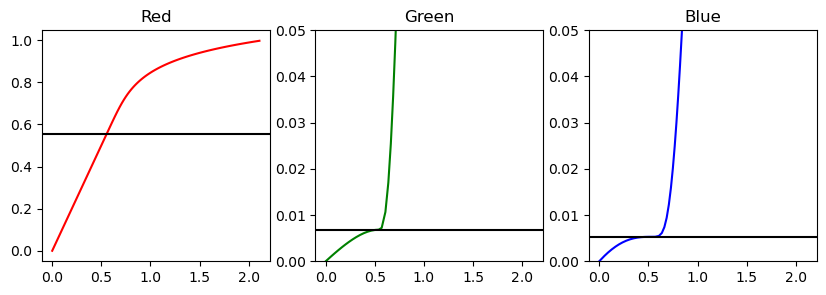

In [36]:
%matplotlib inline

P = arclength_param(skeleton)

print('R_inf from Kubelka-Munk:', R_inf_true)
fig, ax = plt.subplots(1,3, figsize = (10,3))
ax[0].set_title(r'Red')
ax[0].plot(P, skeleton[:,0], color = 'red')
ax[0].axhline(R_inf_true[0], 0, width, color = 'k')

ax[1].set_title(r'Green')
ax[1].plot(P, skeleton[:,1], color = 'green')
ax[1].axhline(R_inf_true[1], 0, width, color = 'k')
ax[1].set_ylim(0,0.05)
#ax[1].set_xlim(0.4,0.6)

ax[2].set_title(r'Blue')
ax[2].plot(P, skeleton[:,2], color = 'blue')
ax[2].axhline(R_inf_true[2], 0, width, color = 'k')
ax[2].set_ylim(0,0.05)
plt.show()




0.8979806681173587 0.5519815245204082 162.68310228273918 %
0.006784838704880359 0.00684963642136438 99.05399772341326 %
0.005300396143765936 0.005300502272035601 99.99799776956564 %


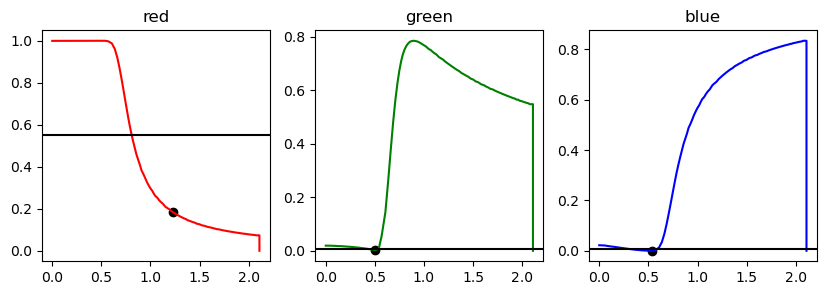

R_inf from Kubelka-Munk: [0.55198152 0.00684964 0.0053005 ]


In [38]:
tol = 1e-3

c = 0
dP = np.gradient(P)
RGB = ['red', 'green', 'blue']
# Compute derivative along the skeleton

fig, ax = plt.subplots(1,3, figsize = (10,3))
for c in range(3):

    dR = np.gradient(skeleton[:,c])
    
    dR_dP = dR / (dP+1e-8)

    ax[c].set_title(r'{}'.format(RGB[c]))
    ax[c].plot(P, dR_dP, color = '{}'.format(RGB[c]))
    ax[c].axhline(R_inf_true[c], 0, width, color = 'k')
    ax[c].scatter(P[np.argmin(dR_dP[:-50])], dR_dP[:-50].min(), color = 'k')
    
    print(skeleton[np.argmin(dR_dP[:-50])][c],  R_inf_true[c], skeleton[np.argmin(dR_dP[:-50])][c]/R_inf_true[c] * 100, '%')

plt.show()
print('R_inf from Kubelka-Munk:', R_inf_true)



### Calculating $R_{\infty}$ using two points on kaartje
This works perfectly, uses formulas from Judd:

- $T^2 = (R-R_0)*(\frac{1}{R_g}-R_0)$
- $a = \frac{1 + R_0^2 - T^2}{2R_0}$
- $b = \sqrt{a^2 - 1}$
- $R_{\infty} = a - b$
- $\frac{S}{K}= \frac{2R_{\infty}}{(1-R_{\infty})^2}$

In [55]:
def transmittance(R, R0, Rg):
    T2 = (R-R0)*(Rg**(-1)-R0)
    return np.sqrt(T2)
    

def R_inf_T(T, R0):
    a = (1+R0**2-T**2)/(2*R0)
    b = np.sqrt(a**2-1)
    R_inf = a - b
    return R_inf

def S_over_K(R_inf):
    return (2*R_inf)/(1-R_inf)**2

def K_and_S(S_K, T, D):
    K = -D**(-1)*np.log(T)
    S = S_K * K
    return K, S

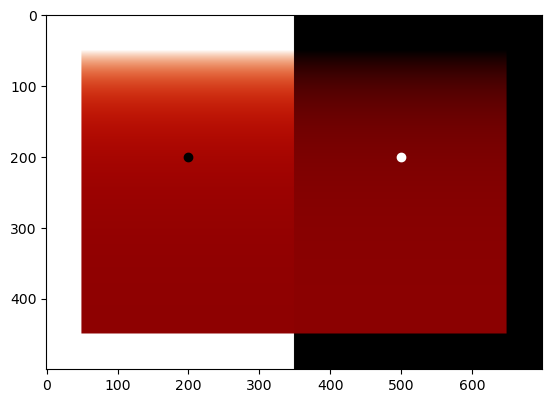

In [57]:
h = 200

fig, ax = plt.subplots(1)
ax.imshow(kaartje)
ax.scatter(200, h, color = 'k')     # Reflectance on white
ax.scatter(500, h, color = 'white')
plt.show()

In [61]:
h = 200
 
R = kaartje[h,200,:]     # Reflectance on white
R0 = kaartje[h,500,:]    # Reflectance on black
Rg = np.array([1.0,1.0,1.0]) # White background

T = transmittance(R, R0, Rg)

R_inf = R_inf_T(T, R0)
S_K = S_over_K(R_inf)

K_est, S_est = K_and_S(S_K, T, 1)

print(R_inf)
print(R_inf_true)

[0.55198152 0.00684964 0.0053005 ]
[0.55198152 0.00684964 0.0053005 ]
